In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score

## kNN function

In [53]:
def KNN(X_train, Y_train, X_test, k, task_type):
    Y_pred = np.zeros(X_test.shape[0])
    for i in range(X_test.shape[0]):
        euclidean = np.sqrt(np.sum(np.square(X_train - X_test[i]), axis=1)) 
        sorted_neighbours = np.argsort(euclidean)
        knns = sorted_neighbours[:k] # get the k nearest neighbours
        
        if task_type == 'regression':
            Y_pred[i] = np.mean(Y_train[knns])
            
        else:
            y_unique, y_counts = np.unique(Y_train[knns], return_counts=True)
            Y_pred[i] = y_unique[np.argmax(y_counts)]
            
    return Y_pred

## Logistic regression

In [54]:
class Logistic_Regression:
    def __init__(self, learning_rate, num_steps =100):
        self.learning_rate = learning_rate
        self.num_steps = num_steps
        self.parameters = None

    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))

    def fit(self, X, Y):
        num_samples, num_features = X.shape[0], X.shape[1]
        self.parameters = np.zeros(num_features)
        for i in range(self.num_steps):
            y_cd = self.sigmoid(np.matmul(X, self.parameters)) 
            gradient = np.matmul(X.T, (y_cd - Y)) / num_samples 
            self.parameters = self.parameters - self.learning_rate * gradient # updating the parameters

    def predict(self, X):
        Y_pred = self.sigmoid(np.matmul(X, self.parameters))
        Y_pred = np.where(Y_pred >= 0.5, 1, 0) # if probability is more than or equal to 0.5, the class is 1 else 0
        return Y_pred

    def roc_predict(self, X):
        return self.sigmoid(np.matmul(X, self.parameters)) # only scores for roc curve

In [55]:
def accuracy_precision_recall(Y_test, Y_pred):
    TP = np.sum((Y_test==1) & (Y_pred==1))
    TN = np.sum((Y_test==0) & (Y_pred==0))
    FP = np.sum((Y_test==0) & (Y_pred==1))
    FN = np.sum((Y_test==1) & (Y_pred==0))
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    return accuracy, precision, recall

In [56]:
def load_data_from_csv(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, 1:-1].values # since first column is the index column-email no
    y = data.iloc[:, -1].values # since last column is the prediction column
    return X, y, data

In [57]:
# Calculating the evaluation metrics based on 5-fold cross validation
def five_fold_cv(input_data_path, model_type, k=1, lr=0.015, num_steps=1000):
    X, Y, temp = load_data_from_csv(input_data_path)
    accuracy = np.zeros(5)
    precision = np.zeros(5)
    recall = np.zeros(5)
    for i in range(5):
        X_test = X[i*1000:(i+1)*1000, :] # each thousand rows are the test set
        Y_test = Y[i*1000:(i+1)*1000]
        X_train = np.delete(X, np.s_[i*1000:(i+1)*1000], axis = 0)
        Y_train = np.delete(Y, np.s_[i*1000:(i+1)*1000], axis = 0)
        if model_type == 'NN':
            # print("predicting with:", model_type, "fold:", i, "k:", k)
            Y_pred = KNN(X_train, Y_train, X_test, k, task_type='classification')
        elif model_type == 'logistic regression':
            # print("predicting with:", model_type, "fold:", i, "learning rate:", lr, "num_steps:", num_steps)
            logistic_model = Logistic_Regression(learning_rate=lr, num_steps=num_steps)
            logistic_model.fit(X_train, Y_train)
            Y_pred = logistic_model.predict(X_test)
        accuracy[i], precision[i], recall[i] = accuracy_precision_recall(Y_test, Y_pred)
    return accuracy, precision, recall

## Q2.2 5-fold cross validation - 1NN

In [20]:
accuracy_2, precision_2, recall_2 = five_fold_cv("emails.csv", model_type="NN", k=1)
for i in range(5):
    print("Fold", i+1, "accuracy:", accuracy_2[i], "precision:", precision_2[i], "recall:", recall_2[i])

Fold 1 accuracy: 0.825 precision: 0.6536312849162011 recall: 0.8210526315789474
Fold 2 accuracy: 0.855 precision: 0.6896551724137931 recall: 0.8664259927797834
Fold 3 accuracy: 0.863 precision: 0.7220543806646526 recall: 0.8415492957746479
Fold 4 accuracy: 0.854 precision: 0.7215568862275449 recall: 0.8197278911564626
Fold 5 accuracy: 0.775 precision: 0.6051948051948052 recall: 0.761437908496732


## Q2.3 5-fold cross validation - Logistic Regression

In [21]:
accuracy_3, precision_3, recall_3 = five_fold_cv("emails.csv", model_type = "logistic regression", lr=0.015, num_steps=1000)
for i in range(5):
    print("Fold", i+1, "accuracy:", accuracy_3[i], "precision:", precision_3[i], "recall:", recall_3[i])

C:\Users\srish\AppData\Local\Temp\ipykernel_43940\4033935508.py:8: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


Fold 1 accuracy: 0.91 precision: 0.891566265060241 recall: 0.7789473684210526
Fold 2 accuracy: 0.897 precision: 0.8222222222222222 recall: 0.8014440433212996
Fold 3 accuracy: 0.891 precision: 0.8277153558052435 recall: 0.778169014084507
Fold 4 accuracy: 0.84 precision: 0.6580188679245284 recall: 0.9489795918367347
Fold 5 accuracy: 0.85 precision: 0.7910447761194029 recall: 0.6928104575163399


## Q2.4 5-fold cross validation with kNN varying k (k=1, 3, 5, 7, 10)

In [22]:
k_values = [1, 3, 5, 7, 10]
accuracy_4_all_k = []
for k in k_values:
    accuracy_4, precision_4, recall_4 = five_fold_cv("emails.csv", model_type="NN", k=k)
    accuracy_4_all_k.append(np.mean(accuracy_4))
    print("average accuracy for k =", k, " is:", np.mean(accuracy_4))

average accuracy for k = 1  is: 0.8344000000000001
average accuracy for k = 3  is: 0.841
average accuracy for k = 5  is: 0.8418000000000001
average accuracy for k = 7  is: 0.8452
average accuracy for k = 10  is: 0.8558


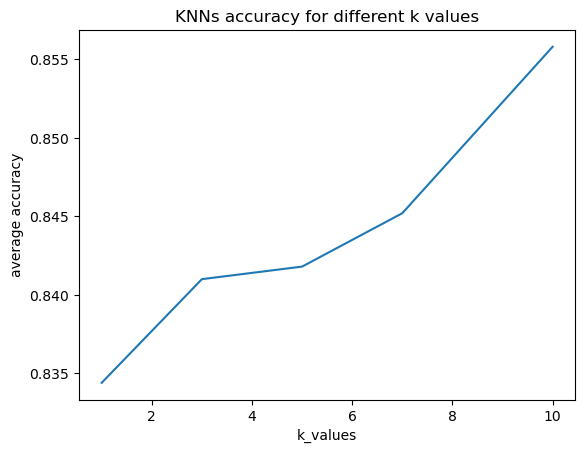

In [58]:
# plotting the accuracy for different k values
plt.plot(k_values, accuracy_4_all_k)
plt.xlabel("k_values")
plt.ylabel("average accuracy")
plt.title("KNNs accuracy for different k values")
plt.show()

## Q2.5 ROC curves based on single training/test setting

In [59]:
X_5_full, Y_5_full, temp = load_data_from_csv("emails.csv")
X_test_5 = X_5_full[4000:5000, :] # using Email 4001-5000 as the test set
Y_test_5 = Y_5_full[4000:5000]
X_train_5 = np.delete(X_5_full, np.s_[4000:5000], axis = 0)
Y_train_5 = np.delete(Y_5_full, np.s_[4000:5000], axis = 0)

# predicting with 5NN
Y_pred_5_NN = KNN(X_train_5, Y_train_5, X_test_5, k=5, task_type='classification')
auc_score_NN = roc_auc_score(Y_test_5, Y_pred_5_NN)
fasle_positive_rate_NN, true_positive_rate_NN, thresholds_NN = roc_curve(Y_test_5, Y_pred_5_NN)

# predicting with logistic regression
logistic_model_5 = Logistic_Regression(learning_rate=0.015, num_steps=1000)
logistic_model_5.fit(X_train_5, Y_train_5)
Y_pred_5_LR = logistic_model_5.roc_predict(X_test_5) ##using scores rather than predicted class
auc_score_LR = roc_auc_score(Y_test_5, Y_pred_5_LR)
fasle_positive_rate_LR, true_positive_rate_LR, thresholds_LR = roc_curve(Y_test_5, Y_pred_5_LR)

C:\Users\srish\AppData\Local\Temp\ipykernel_43940\1264378094.py:8: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


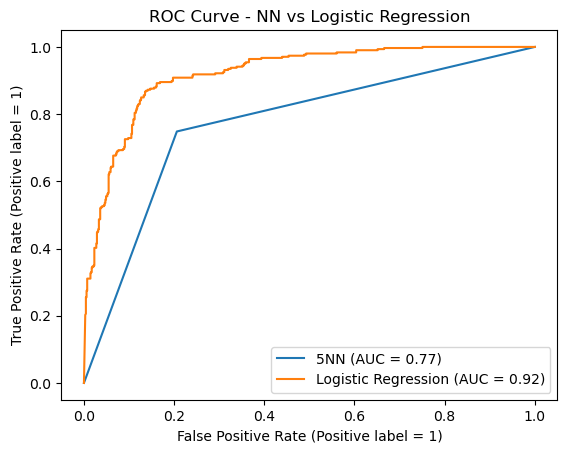

In [51]:
# plotting ROC curve
fig, ax = plt.subplots()
ax.plot(fasle_positive_rate_NN, true_positive_rate_NN, label='5NN (AUC = ' + str(round(auc_score_NN, 2)) + ')')
ax.plot(fasle_positive_rate_LR, true_positive_rate_LR, label='Logistic Regression (AUC = ' + str(round(auc_score_LR, 2)) + ')')
ax.set_xlabel('False Positive Rate (Positive label = 1)')
ax.set_ylabel('True Positive Rate (Positive label = 1)')
ax.set_title('ROC Curve - NN vs Logistic Regression')
ax.legend()
plt.show()